In [379]:

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import joypy as jp
import sympy as sym
from time import time
#sym.init_printing()

#from pysde import *
from functools import partial
from math import log
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from mpl_toolkits.mplot3d import Axes3D

from collections import Counter


import seaborn as sns
sns.set()

In [127]:
gamma = 0.0138172

ribo_decay = 6.205e-6
prot_decay = 6.205e-6

r_R = 63
r_P = 63
l_R = 5000
l_P = 975

volume = 1e-18

In [128]:
n_ribo_volume = lambda volume : (7.280245377599019e21*(1 + 1.3322199014570686e-12/
    volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
1.3322199014570686e-12/volume**0.6454883435592754) + 
  1.3525663798553437e-6/volume**0.6454883435592754)

n_prot_volume = lambda volume : 7.466918335998994e18*(volume**0.6971221467560254)

div_time_volume = lambda volume : 1.4881390043125451e-8/volume**0.6454883435592754


def reaction_rates(volume, X, mu_ribo_synth= gamma*r_R/l_R, mu_prot_synth= (1-gamma)*r_P/l_P, mu_ribo_decay= ribo_decay, mu_prot_decay= prot_decay):
    
    mu_vector = np.array([mu_ribo_synth, mu_prot_synth, mu_ribo_decay, mu_prot_decay])
    scaled_rates = np.power(X.repeat(LHS.shape[1],1)/volume,LHS).prod(axis=0)
    
    return mu_vector * scaled_rates * volume
    
#     F = np.array([[mu_ribo_synth*volume*(X[0]/volume)**1], #ribo synthesis
#                   [mu_prot_synth*volume*(X[0]/volume)**1], #prot synthesis
#                   [mu_ribo_decay*volume*(X[0]/volume)**1], #ribo decay
#                   [mu_prot_decay*volume*(X[1]/volume)**1]]) #prot decay
    
    #return F.reshape(-1)

In [194]:
LHS = np.array([[1,1,1,0],
               [0,0,0,1]])

RHS = np.array([[2,1,0,0],
               [0,1,0,0]])

S = RHS - LHS

# X = np.array([[n_ribo_volume(1e-18)],
#               [n_prot_volume(1e-18)]])

# F = reaction_rates(volume = 1e-18, X=X)

# E = S @ np.diag(F)

# J = (1/X @ F.reshape(1,-1) * LHS).T

# A = S @ J

#dphi_dt = S @ F


In [794]:
type(1e-18)

float

In [848]:
#TODO add system size!

def dZ_dt(state, t=0, volume=1e-18):
    
    Z = state.reshape(2*LHS.shape[0]+1, LHS.shape[0])
    
    F = reaction_rates(volume = 1e-18, X=np.atleast_2d(Z[0]).T)
    E = S @ np.diag(F)
    J = (1/X @ F.reshape(1,-1) * LHS).T
    A = S @ J
    
    V = Z[1:A.shape[0]+1]
    G = Z[A.shape[0]+1:]
    
    phidot = S @ F
    Vdot = A @ V + V @ A.T + E @ E.T
    Gdot = A @ G
    
    ode_list = np.vstack((phidot, Vdot, Gdot)).reshape(-1)
    
    return ode_list


In [849]:
riboprot_init = np.array([n_ribo_volume(1e-18), n_prot_volume(1e-18)])
global_init = np.vstack([riboprot_init.reshape(1,2),np.identity(2), np.identity(2)])

In [850]:
testres = odeint(dZ_dt, y0=global_init.reshape(-1), t=np.linspace(0,div_time_volume(1e-18),1e6), args=(1e-18,)).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [944]:
def trajectory(volume=1e-18, iterations=1000000):
    
    riboprot_init = np.array([n_ribo_volume(volume), n_prot_volume(volume)])
    global_init = np.vstack([riboprot_init.reshape(1,2),np.identity(2), np.identity(2)])
    
    T = np.linspace(0,div_time_volume(volume),iterations)
    
    solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), t=T, args=(volume,)).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])
    
    X_t = solved_odes[:,0,:]
    V_t = solved_odes[:,1:A.shape[0]+1,:]
    G_t = solved_odes[:,A.shape[0]+1:,:]
    cov_t = V_t[0] @ G_t.transpose(0,2,1)
    
    var_ribo = V_t[:,0,0]
    var_prot = V_t[:,1,1]
    cov_riboprot = V_t[:,0,1]
    
    cov_ribo_over_time = cov_t[:,0,0]
    cov_prot_over_time = cov_t[:,1,1]
    cov_riboprot_over_time = cov_t[:,0,1]

    rho_ribo = np.array([cov_ribo_over_time[t]/(np.sqrt(var_ribo[0])*np.sqrt(var_ribo[t])) for t in range(1,iterations)])
    rho_prot = np.array([cov_prot_over_time[t]/(np.sqrt(var_prot[0])*np.sqrt(var_prot[t])) for t in range(1,iterations)])
    
    mi_ribo = -0.5*np.log(1-rho_ribo**2)# if rho**2 != 1 else np.inf
    mi_prot = -0.5*np.log(1-rho_prot**2)
    
    return mi_ribo

In [964]:
class Trajectory:
    
    def __init__(self, volume=1e-18, iterations=1000000):
        self.volume = volume
        self.iterations = iterations
        
        riboprot_init = np.array([n_ribo_volume(volume), n_prot_volume(volume)])
        global_init = np.vstack([riboprot_init.reshape(1,2),np.identity(2), np.identity(2)])

        T = np.linspace(0,div_time_volume(volume),iterations)

        solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), t=T, args=(volume,)).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])

        self.X_t = solved_odes[:,0,:]
        self.V_t = solved_odes[:,1:A.shape[0]+1,:]
        self.G_t = solved_odes[:,A.shape[0]+1:,:]
        cov_t = V_t[0] @ G_t.transpose(0,2,1)

        var_ribo = self.V_t[:,0,0]
        var_prot = self.V_t[:,1,1]
        cov_riboprot = self.V_t[:,0,1]

        cov_ribo_over_time = cov_t[:,0,0]
        cov_prot_over_time = cov_t[:,1,1]
        cov_riboprot_over_time = cov_t[:,0,1]

        rho_ribo = np.array([cov_ribo_over_time[t]/(np.sqrt(var_ribo[0])*np.sqrt(var_ribo[t])) for t in range(1,iterations)])
        rho_prot = np.array([cov_prot_over_time[t]/(np.sqrt(var_prot[0])*np.sqrt(var_prot[t])) for t in range(1,iterations)])

        self.mi_ribo = -0.5*np.log(1-rho_ribo**2)# if rho**2 != 1 else np.inf
        self.mi_prot = -0.5*np.log(1-rho_prot**2)
        
        
        
    def contour(self, fractions=20):
        index_correction = np.zeros(fractions)
        index_correction[-1] = -1
        indices = (np.linspace(0,1,fractions) * self.iterations + index_correction).astype('int')

        plt.subplots(1, figsize=(10,10))

        x_contour = np.linspace(np.min(self.X_t[:,0])*0.9,np.max(self.X_t[:,0])*1.1,100)
        y_contour = np.linspace(np.min(self.X_t[:,1])*0.9,np.max(self.X_t[:,1])*1.1,100)
        x_contour, y_contour = np.meshgrid(x_contour, y_contour)
        points_contour = np.stack((x_contour, y_contour), axis=-1)


        z_contours = [scipy.stats.multivariate_normal(mean=self.X_t[i], cov=self.V_t[i]).pdf(points_contour) for i in indices] 


        for i,z in enumerate(z_contours):
            plt.contour(x_contour, y_contour, z)
            plt.annotate('t= {}'.format("{:.2}".format(div_time_volume(self.volume)*indices[i]/1e6) ),self.X_t[indices[i]]*np.array([0.95,1.1]), size=8)

        plt.xlabel('Number of ribosomes')
        plt.ylabel('Number of proteins')

        plt.show()



        


In [945]:
#trajectory(1e-18)
trajectory(1e-18)
#testres = odeint(dZ_dt, global_init.reshape(-1), t=np.linspace(0,div_time_volume(1e-18),1e6)).reshape(-1,LHS.shape[0]+1, LHS.shape[0])

array([2.54005162e+00, 2.19657804e+00, 1.99692638e+00, ...,
       1.17389074e-04, 1.17389038e-04, 1.17389002e-04])

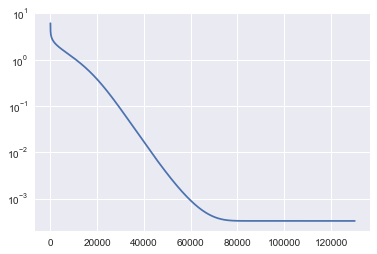

In [949]:
plt.plot(trajectory(1e-21))
plt.yscale('log')
plt.show()

In [965]:
trajectories_by_volume = [Trajectory(volume=v) for v in np.logspace(-22,-14,9)]

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in add
  app.launch_new_instance()


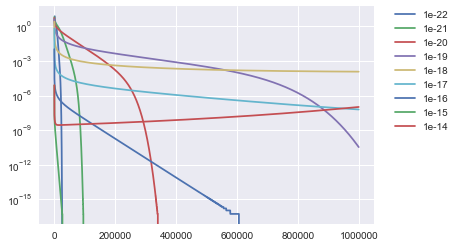

In [984]:
for traj in trajectories_by_volume:
    plt.plot(traj.mi_ribo, label=traj.volume)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

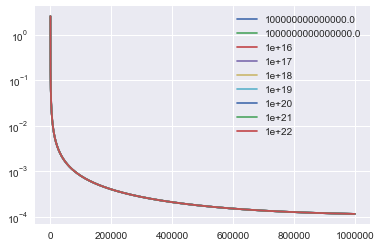

In [942]:
for traj in trajectories_by_volume:
    plt.plot(mi_ribo, label=traj.volume)
    plt.yscale('log')
    plt.legend()
plt.show()

In [855]:
X_t = testres[:,0,:]
V_t = testres[:,1:A.shape[0]+1,:]
G_t = testres[:,A.shape[0]+1:,:]
cov_t = V_t[0] @ G_t.transpose(0,2,1)

In [856]:
var_ribo = V_t[:,0,0]
var_prot = V_t[:,1,1]
cov_riboprot = V_t[:,0,1]

In [857]:
cov_ribo_over_time = cov_t[:,0,0]
cov_prot_over_time = cov_t[:,1,1]
cov_riboprot_over_time = cov_t[:,0,1]


In [858]:
rho_ribo_t = np.vectorize(lambda  t : cov_ribo_over_time[t]/(np.sqrt(var_ribo[0])*np.sqrt(var_ribo[t])))
rho_prot_t = np.vectorize(lambda  t : cov_prot_over_time[int(t)]/(np.sqrt(var_prot[0])*np.sqrt(var_prot[int(t)])))


def mutual_info(t, species): 
    
        if species=='ribo':
            rho = cov_ribo_over_time[t]/(np.sqrt(var_ribo[0])*np.sqrt(var_ribo[t])) 
        elif species=='prot':
            rho = cov_prot_over_time[t]/(np.sqrt(var_prot[0])*np.sqrt(var_prot[t])) 
        
        mutual_info = -0.5*np.log(1-rho**2) if rho**2 != 1 else np.inf
        return mutual_info

    
mutual_info = np.vectorize(mutual_info)
mi_ribo = mutual_info(np.arange(1,1000000), species='ribo')
mi_prot = mutual_info(np.arange(1,1000000), species='prot')

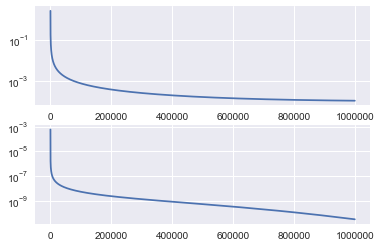

In [712]:
fig, axes = plt.subplots(2)

axes[0].plot(mi_ribo)
axes[1].plot(mi_prot)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.show()

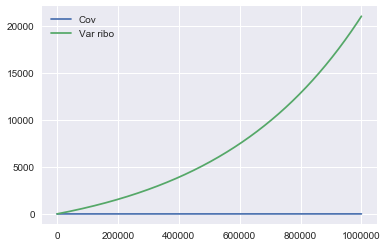

In [630]:
plt.plot(cov_ribo_over_time, label='Cov')
plt.plot(var_ribo*var_ribo[0], label='Var ribo')
plt.legend()
plt.show()

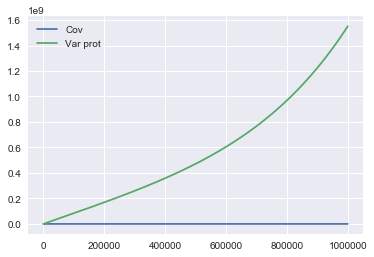

In [632]:
plt.plot(cov_prot_over_time, label='Cov')
plt.plot(var_prot, label='Var prot')
plt.legend()
plt.show()

In [476]:
z_contour = scipy.stats.multivariate_normal(mean=X_t[-1], cov=V_t[-1]).pdf(points_contour)#[16300,5.970e6])

/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


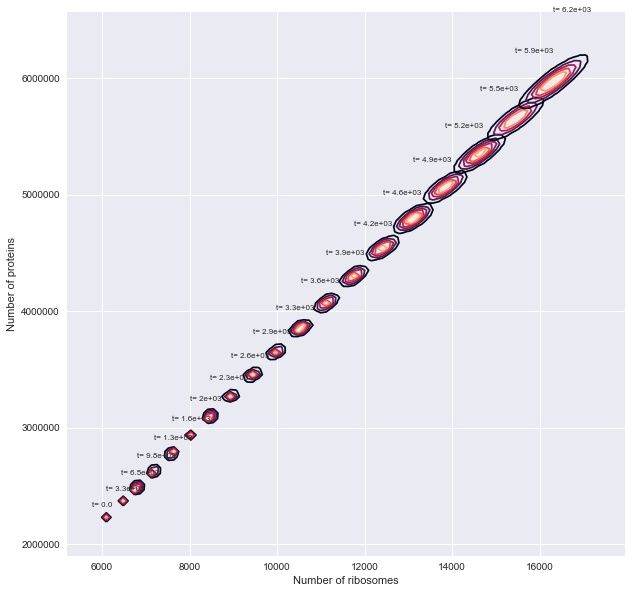

In [905]:
iterations = 1000000
fractions = 20
index_correction = np.zeros(fractions)
index_correction[-1] = -1
indices = (np.linspace(0,1,fractions) * iterations + index_correction).astype('int')

plt.subplots(1, figsize=(10,10))

x_contour = np.linspace(np.min(X_t[:,0])*0.9,np.max(X_t[:,0])*1.1,100)
y_contour = np.linspace(np.min(X_t[:,1])*0.9,np.max(X_t[:,1])*1.1,100)
x_contour, y_contour = np.meshgrid(x_contour, y_contour)
points_contour = np.stack((x_contour, y_contour), axis=-1)


z_contours = [scipy.stats.multivariate_normal(mean=X_t[i], cov=V_t[i]).pdf(points_contour) for i in indices] 


for i,z in enumerate(z_contours):
    plt.contour(x_contour, y_contour, z)
    plt.annotate('t= {}'.format("{:.2}".format(div_time_volume(1e-18)*indices[i]/1e6) ),X_t[indices[i]]*np.array([1,1.1]), size=8)

plt.xlabel('Number of ribosomes')
plt.ylabel('Number of proteins')

plt.show()

In [897]:
np.max(X_t[:,0])*1.1

17943.499256732375

In [421]:
"{:.2E}".format(div_time_volume(1e-18)*indices[0])

'0.00E+00'

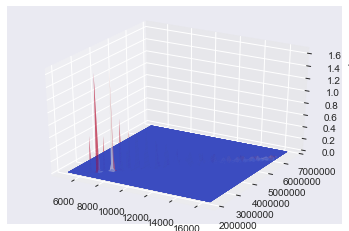

In [872]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for i,z in enumerate(z_contours):
    ax.plot_surface(x_contour, y_contour, z, cmap='coolwarm', alpha=0.4)
    #plt.annotate('t= {}'.format("{:.2}".format(div_time_volume(1e-18)*indices[i]/1e6) ),X_t[indices[i]]*np.array([1,1.1]), size=8)

# ax.plot_surface(x_contour, y_contour, z_contour_0, cmap='coolwarm', alpha=0.4)
# ax.plot_surface(x_contour, y_contour, z_contour_1, cmap='coolwarm', alpha=0.4)
# ax.plot_surface(x_contour, y_contour, z_contour_2, cmap='coolwarm', alpha=0.4)
# ax.plot_surface(x_contour, y_contour, z_contour_3, cmap='coolwarm', alpha=0.4)
# ax.plot_surface(x_contour, y_contour, z_contour_4, cmap='coolwarm', alpha=0.4)
# ax.plot_surface(x_contour, y_contour, z_contour_f, cmap='coolwarm', alpha=0.4)

#plt.colorbar()

plt.show()

In [363]:
1e3

1000.0

In [171]:

def dphi_dt(X, t=0):
    #X[0] = [ribosomes](t)
    #X[1] = [proteins](t)
    F = reaction_rates(volume = 1e-18, X=np.atleast_2d(X).T)
    return np.array([S @ F, np.identity(2)])

In [228]:
A[0] @ np.eye(2) + np.eye(2)[0] @ A.T + E[0] @ E.T

array([1.01194902, 0.06372258])

In [176]:
riboprot_init = np.array([n_ribo_volume(1e-18), n_prot_volume(1e-18)])
global_init = np.array([riboprot_init,np.identity(2)])
odeint(dphi_dt, global_init, t=np.linspace(0,div_time_volume(1e-18),1e6))

ValueError: could not broadcast input array from shape (2,2) into shape (2)

In [157]:
ribo_t, prot_t = odeint(dphi_dt, np.array([n_ribo_volume(1e-18), n_prot_volume(1e-18)]), t=np.linspace(0,div_time_volume(1e-18),1e6)).T
#plt.yscale('log')

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


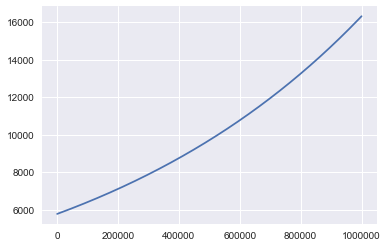

In [159]:
plt.plot(ribo_t)
plt.show()

In [542]:
scipy.stats.multivariate_normal(cov=np.array([[20,2],[3,2]]),mean=[2,2]).cov

array([[20.,  2.],
       [ 3.,  2.]])